# Ovation Aurora Short Term Forecast
Short notebook ingesting text file, and saving as pandas array, along with forecast timestamp.

Link: http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt

On the website, service looks like:
<table>
    <tr>
        <th>Northern Hemisphere</th>
        <th>Southern Hemisphere</th>
    </tr>
    <tr>
        <td><img src="http://services.swpc.noaa.gov/images/aurora-forecast-northern-hemisphere.png" width=300></td>
        <td><img src="http://services.swpc.noaa.gov/images/aurora-forecast-southern-hemisphere.png" width=300></td>
    </tr>
</table>

In [1]:
from datetime import datetime
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

# Will need to fix the connection to get the update every n minutes,
# but for now devputer can't connect to the Internet.
def ovation_forecast():
    """Retrieves the OVATION aurora forecast from the swpc.noaa site. If
    Internet is down, retrieves local copy. Needs no args.    
    Extent:
    1024 values covering 0 to 360 degrees in longitude (0.32846715 deg/px)
    512 values covering -90 to 90 degrees in latitude (0.3515625 deg/px)
    Returns:
    array: pandas array of the forecast
    datetime: date & time of forecast
    extent: projection bounds used for plotting.
    
    None -> np.array, datetime, tuple"""
    
    extent = (-180, 180, -90, 90)
    url = 'http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt'
    file = 'aurora-nowcast-map.txt'
    timestamp = None
        
    def file_modified(filename):
        t = os.path.getmtime(filename)
        t = datetime.fromtimestamp(t)
        elapsed_time = datetime.now() - t
        return elapsed_time.total_seconds()
    
    # Having problems with local proxy, using local copy instead.
    # [ ] FIXME: Proxy connection issues
    """# Download dataset if not already present
    if not os.path.exists(file) or file_modified(file) >= 300:
        r = requests.get(url, headers=headers)
        output = open(file, 'wb')
        output.write(r.content)
        output.close()"""
        
    # Get timestamp
    with open(file) as f:
        for line in f:
            if line.startswith('# Product Valid At:'):
                timestamp = datetime.strptime(line[-17:-1], '%Y-%m-%d %H:%M')

    # Get data grid
    # [ ] TODO: find a way to only open file once.
    array = pd.read_csv(file, comment='#', delimiter='\s+', header=None)
    
    return array, timestamp


# Low-tech unit testing
_array, _timestamp = ovation_forecast()
assert _array.shape == (512, 1024)
assert str(_timestamp)[0:2] == '20'  # From '2017...'
print('Image ready')

Image ready


## Visualization
### Equirectangular Projection (Plate Carrée)
We'll start off with a basic matplotlib figure, where each pixel in the data file represents approximately a third of a degree. The figure below, however, has been expanded a bit, with bicubic interpolation to smooth the values between the dots. With proper transparency, this could be overlaid on top of the base map in Google Earth.

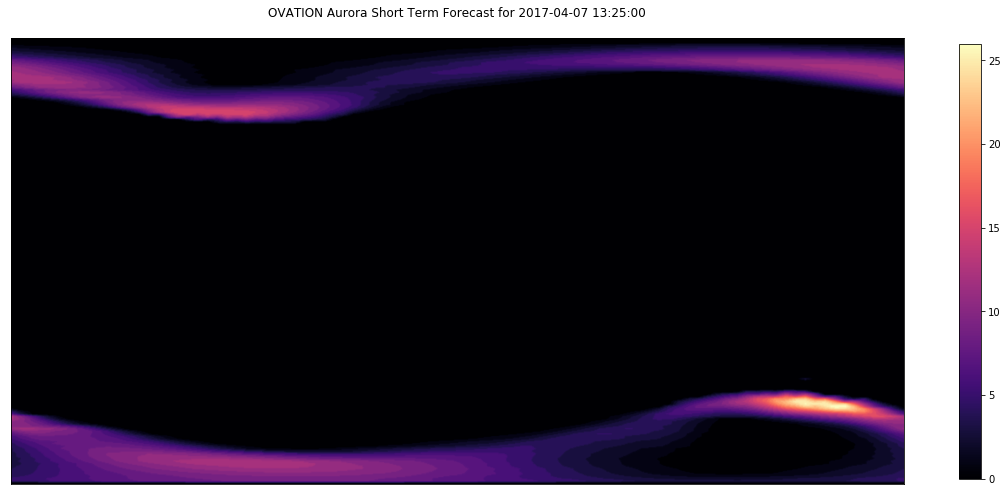

In [2]:
plt.figure(figsize=(20, 20))
plt.imshow(_array, 
           interpolation='bicubic',
           cmap='magma',
           origin='lower',
          )
plt.colorbar(shrink=0.4)
plt.title('OVATION Aurora Short Term Forecast for {}\n'.format(_timestamp))
plt.xticks([]), plt.yticks([])
plt.show()

### Transparency
That's great, but what really need is an extra transparency channel to our visualization. For that, we'll need to define our own matplotlib color map, which is [explained here](http://matplotlib.org/examples/pylab_examples/custom_cmap.html).

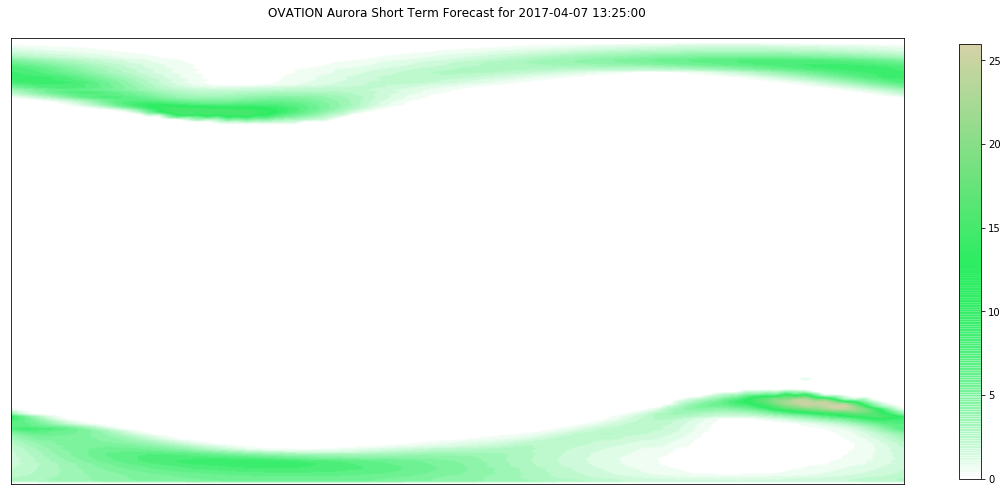

In [3]:
def aurora_cmap():
    """Return a colormap with aurora-like colors
    and transparency."""
    from matplotlib.colors import LinearSegmentedColormap
    stops = {'red': [(0.00, 0.1725, 0.1725),
                     (0.50, 0.1725, 0.1725),
                     (1.00, 0.8353, 0.8353)],

             'green': [(0.00, 0.9294, 0.9294),
                       (0.50, 0.9294, 0.9294),
                       (1.00, 0.8235, 0.8235)],

             'blue': [(0.00, 0.3843, 0.3843),
                      (0.50, 0.3843, 0.3843),
                      (1.00, 0.6549, 0.6549)],

             'alpha': [(0.00, 0.0, 0.0),
                       (0.50, 1.0, 1.0),
                       (1.00, 1.0, 1.0)]}

    return LinearSegmentedColormap('aurora', stops)

plt.figure(figsize=(20, 20))
plt.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower',
          )
plt.colorbar(shrink=0.4)
plt.title('OVATION Aurora Short Term Forecast for {}\n'.format(_timestamp))
plt.xticks([]), plt.yticks([])

plt.show()


### Exporting the transparent image
There are many different filetypes possible, but let's go with a simple png:

In [4]:
plt.savefig('temp.png')

## Basemap
The data is provided as Plate Carrée, so we can use this to project the image onto the globe. For this, we use the matplotlib contrib module called basemap.

Basemap does not come pre-packaged with Anaconda3, so we install it with:

    $ conda install -c conda-forge basemap

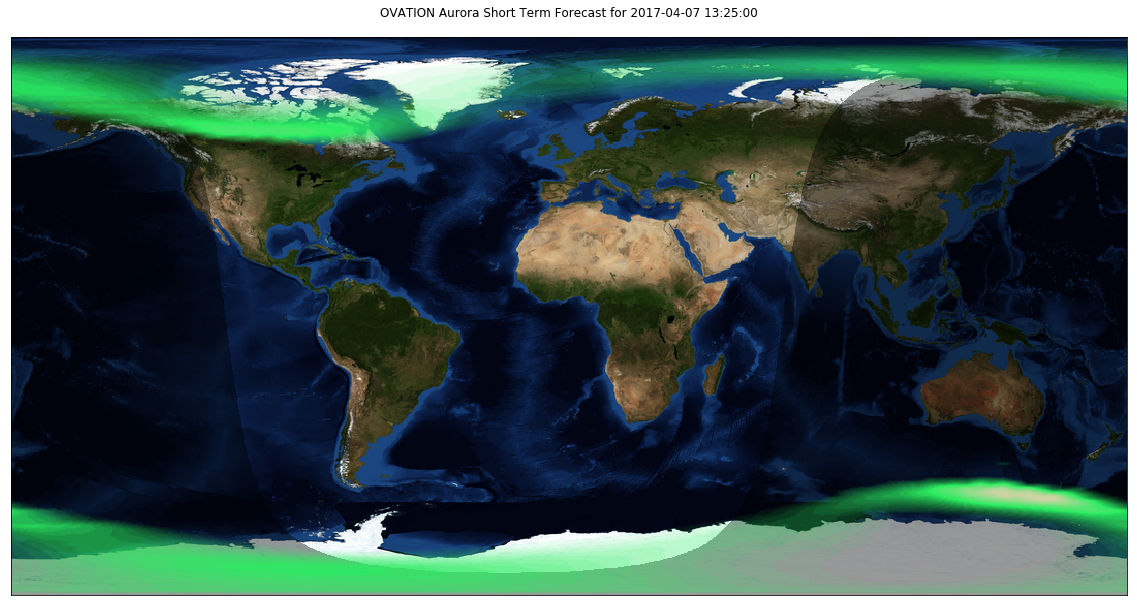

In [5]:
# The method call `map.imshow()` gets a deprecation warning in matplotlib 2,
# which we'll silence.
import warnings
warnings.filterwarnings('ignore')

from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(20, 20))
map = Basemap(projection='cyl')
map.bluemarble(scale=0.2)
map.nightshade(date=_timestamp,
               alpha=0.4,
               zorder=1)
map.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           origin='lower',
           zorder=2)
plt.title('OVATION Aurora Short Term Forecast for {}\n'.format(_timestamp))
plt.show()

## Other projections
That's amazing! But we're actually forced to use the standard equidistant cylindrical projection so that it matches the aurora image.

Can we instead recreate the same projection as the two images on top? We'll need to modify the `map.imshow()` call, to use `map.pcolor()` instead.

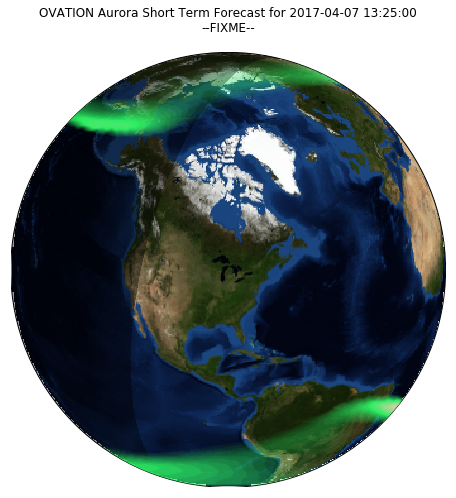

In [6]:
plt.figure(figsize=(8, 8))
map = Basemap(projection='ortho',
              lat_0=45,
              lon_0=-85,
              resolution='l')
map.bluemarble(scale=0.2)
map.nightshade(date=_timestamp,
               alpha=0.4,
               zorder=1)
map.imshow(_array, 
           interpolation='bicubic',
           cmap = aurora_cmap(),
           extent=(0, 180, -90, 90),  # [ ] FIXME: Extent doesn't affect aurora position on globe.
           origin='lower',
           zorder=2)
plt.title('OVATION Aurora Short Term Forecast for {}\n--FIXME--\n'.format(_timestamp))
plt.show()